In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from math import sin, cos, pi

def plot_function(f,xmin,xmax,**kwargs):
    ts = np.linspace(xmin,xmax,1000)
    plt.plot(ts,[f(t) for t in ts], **kwargs)

## Chapter 12 물리계 최적화하기
####   
#### 포탄 시뮬레이터를 만들 것이다. 
#### 이 시뮬레이터는 발사 각도를 입력으로 받아서 오일러 방법을 실행하여 포탄이 지면에 닿을 때 까지 순간 움직임을 시물레이션하고, 시간에 따른 포탄의 위치 리스트를 출력한다.
#### 최종 수평 위치를 추력하는데 이 위치는 탄착점 또는 사거리에 해당한다.
#### 즉 발사 각도를 입력하면 해당 각도에서 포탄의 사거리가 출력된다.
#### 우선 사거리를 최대할 수 있는 각도를 찾을 것이다.
#### 각도를 찾는 두가지 방법이 있는데 첫번째는 시뮬레이션을 통해 그래프를 그려 찾는 것이고, 두번째는 시뮬레이터를 하지않고 발사각도 세타의 함수로서 발사체의 사거리에 대한 수식을 찾는 것이다.
---
## 12.1 포물선 운동 시뮬레이션 테스트하기
#### 첫번째로 포탄의 비행 경로를 계산하는 시뮬레이터를 만들 것이다.
#### 만들 시뮬레이션은 발사 각도와 제어하고자 하는 매개변수를 입력으로 받아 지면에 충돌할 때까지 시간에 따른 포탄의 위치를 리턴한다.
---
### 12.1.1 오일러 방법으로 시뮬레이션 만들기
#### 시뮬레이션을 진행할 때 수평방향은 x, 수직 방향은 z방향이라고 하겠다. x,y 로 정의하게 되면 나중에 3차원으로 넘어갈 때 동일하게 사용하기 위함이다.
#### 포탄이 발사되는 각도를 θ, 포탄의 초기 속도를 v라고 하면 이동 중인 객체의 속력 v는 속도벡터의 크기로 정의하므로 |v|가 되고 x성분과 z성분은 vx = |v|* cos(θ), vz = |v|* sin(θ)가 된다. 

In [1]:
def trajectory(theta,speed=20,height=0,dt=0.01,g=-9.81): # 타임스텝 dt, 중력장 g, 각도 θ
    vx = 20 * cos(pi * theta / 180) # 포탄의 속도를 x,z 방향의 속도로 표현
    vz = 20 * sin(pi * theta / 180)
    t,x,z = 0, 0, height
    ts, xs, zs = [t], [x], [z] # 저장할 시간, x,z 위치 값
    while z >= 0: # 지면 위에 있을 때만 실행
        t += dt
        vz += g * dt # z축에 중력 작용 -> 속도 가변
        x += vx * dt # x축에는 아무런 힘이 작용하지 않음 -> 속도 일정
        z += vz * dt
        ts.append(t)
        xs.append(x)
        zs.append(z)
    return ts, xs, zs

In [6]:
def plot_trajectories(*trajs,show_seconds=False):
    for traj in trajs:
        xs, zs = traj[1], traj[2]
        plt.plot(xs,zs)
        if show_seconds:
            second_indices = []
            second = 0
            for i,t in enumerate(traj[0]):
                if t>= second:
                    second_indices.append(i)
                    second += 1
            plt.scatter([xs[i] for i in second_indices], [zs[i] for i in second_indices])
    xl = plt.xlim()
    plt.plot(plt.xlim(),[0,0],c='k')
    plt.xlim(*xl)
    
    width = 7
    coords_height = (plt.ylim()[1] - plt.ylim()[0])
    coords_width = (plt.xlim()[1] - plt.xlim()[0])
    plt.gcf().set_size_inches(width , width * coords_height / coords_width)

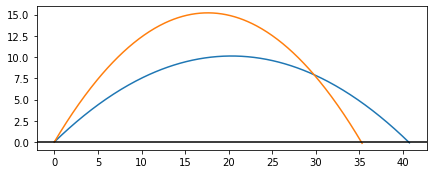

In [8]:
plot_trajectories(trajectory(45), trajectory(60))

### 12.1.2 궤적의 특성 측정하기
#### 궤적이 어떻게 생겼나 보기 위해서는 궤적의 전체 값을 알아야 하지만 최종적으로 어디에 도착하는가를 보기위해서는 모든 값이 필요하지는 않다.
#### 위의 사유로 trajectory 함수의 결과를 입력으로 받아 사거리 또는 탄착점을 추출하는 함수를 만들것이다.
#### 입력 궤적 traj[1]은 x좌표의 리스트에 해당하고, traj[1],[-1]은 이 리스트의 마지막 성분이 된다.

In [9]:
def landing_position(traj):
    return traj[1][-1]

In [11]:
def hang_time(traj): # 체공시간 측정
    return traj[0][-1]
def max_height(traj): # 최대 높이 출력
    return max(traj[2])

---
### 12.1.3 서로 다른 발사각 살펴보기
#### tajectory 함수는 발사 각도를 입력으로 받아 체공 시간 동안 전체 시간 데이터 및 포탄의 위치 데이터를 생성한다. 
#### landing_position 함수는 척도를 계산하는 함수로 데이터를 입력으로 받아 수 하나를 생성한다.
#### 발사 각도가 탄착점에 미치는 효과를 알아보기 위해 발사각도를 여러 다른 값으로 바꾸어가며 얻은 탄착점을 플롯으로 찍어보겠다.

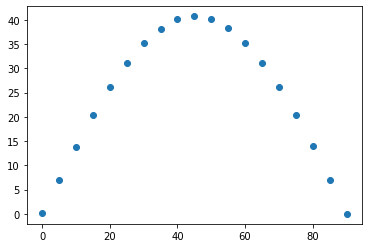

In [14]:
angles = range(0,95,5) # 0부터 90까지 5씩 증가, 마지막 95는 포함되지 않음.
landing_positions = [landing_position(trajectory(theta)) for theta in angles]
plt.scatter(angles,landing_positions) # 대략 45도 부근에서 최대값을 가짐. 

## 12.2 최적 사거리 계산하기
#### 미분적분학을 사용해 대포의 최대 사거리와 최대 사거리를 만드는 발사 각도를 계산할 수 있다.
#### 처음에는 발사각도 θ에 대한 함수로 사거리 r을 알려주는 수식을 구하겠다.
#### 그 뒤에는 도함수를 사용해 함수 r(θ)의 최대값과 이 때의 각도 θ를 구하는 기법을 진행할 것이다.
#### 도함수 r'(θ)가 0이 아닌 θ값은 r(θ)가 최대값인 θ값이기도 하다. 
#### r(θ)의 그래프를 살펴보고 기울기의 변화를 살펴보겠다.
---
### 12.2.1 발사각의 함수로 발사체의 사거리 구하기

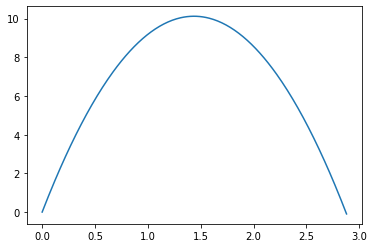

In [15]:
trj = trajectory(45) # θ=45도
ts,zs = trj[0],trj[2]
plt.plot(ts,zs)

#### 가속도는 중력으로 인해 z''(t) = g가 된다. z의 초기 속도가 z'(0) = |v| * sin(θ)이며, 초기 z위치가 z(0) = 0이다. 
#### 위치 함수 z(t)를 복구하려면 가속도 z''(t)를 두번 적분해서 구할 수 있다.
#### 첫번째 적분을 하게 되면 당연하게 속도가 나온다. z'(t) = |v| * sin(θ) +gt 가 된다.
#### 두번째 적분을 하게되면 위치가 나온다. z(t) = |v| * sin(θ) * t + 0.5 * g * t^2 

In [16]:
def z(t):
    return 20*sin(45*pi/180)*t + (-9.81/2)*t**2 # 45도를 라디안 값으로 변경

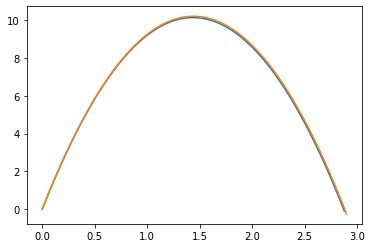

In [18]:
plt.plot(ts,zs)
plot_function(z,0,2.9) # 위에 구한 시뮬레이션과 동일함

#### 초기 속도 |v| * sin(θ)를 vx라고 표현하면 z(t) = vz * t + gt^2 * 0.5 가 된다.
#### z(t) = 0 을 만족하면 t 값을 구하면 그 값은 포탄의 총 제공시간이 된다.
#### 근의 공식을 사용하면 당연하게 z(t) = 0을 만족하는 값은 두개가 나온다.
#### 생각을 조금만 해보면 처음에 출발할때 z(t) = 0의 값으로 출발하는 것을 알수있다. 
#### 즉  z = 0에서 포탄이 출발함을 확인해주는 적합성 확인 역할을 한다고 할 수 있다.
#### 체공 시간이 Δt  = -2vz/g = -2|v|sin(θ)/g 로 계산된다고 할 수 있다.
#### 이때의 사거리는 r = vx * Δt가 된다. 
#### 정리하면 r(θ) = -(2 * |v|^2)/ g * sin(θ) * cos(θ)가 된다.

In [19]:
def r(theta):
    return (-2*20*20/-9.81)*sin(theta*pi/180) * cos(theta*pi/180)

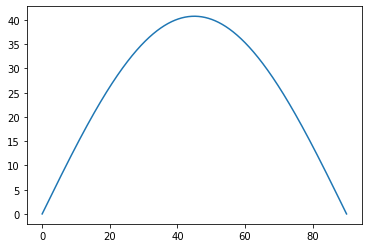

In [27]:
plot_function(r,0,90)

#### 함수 r(θ)의 수식을 알면 모든 발사각도에서 대포의 사거리에 대해 알 수 있고, 여러번 반복하는 것보다 비용적으로 저렴하는 장점이 있다. #### 또한 함수 r(θ)가 매끄럽기 때문에 도함수를 취할 수 있다. 이를 통해 발사체의 사거리가 발사 각도에 대해 어떻게 변화하는지 알 수 있다.
---
### 12.2.2 최대사거리 구하기
#### r(θ)의 그래프가 매끈하고 미분이 가능함으로 r'(θ) 를 구할 수 있다.
#### 발사 각도를 0에서부터 증가시키면 사거리가 비례해서 계속 증가하는 것이 아니라 증가 비율이 감소하고, 결과적으로 사거리가 감소하게 된다.
#### 여기서의 핵심은 r'(θ)가 양수이면 사거리가 θ에대해 증가하고, r'(θ)가 0을 지나 음수가 되면 사거리는 θ에 대해 감소하게 된다.
#### 즉 도함수가 0인 r(θ)는 최대값을 가진다.
#### r(θ) = -(2 * |v|^2)/ g * sin(θ) * cos(θ)을 미분할 것이다.
#### 이때 sin(θ)cos(θ)에 있는 것들은 모두 상수다. 고로 삼각함수의 곱으로 이루어진 값만 곱의 미분법을 사용해 미분하면 된다.
#### r'(θ) = -(2 * |v|^2)/ g * (cos(θ)^2 - sin(θ)^2)이 된다.
#### cos(θ)^2 - sin(θ)^2은 삼각함수 항등식의 cos(2θ)가 된다. 고로 cos(2θ) = 0 의 값을 찾으면 된다.
#### 기존 cos(θ)함수는 90,270,430도에서 0 값을 가진다.
#### θ가 2θ로 두배가 되었으니 45,135,215도에서 0값을 가지게 된다.
#### 결론적으로 45,135,215... 도에서 사거리는 최대가 된다.

In [28]:
r(45)

40.774719673802245

In [29]:
r(135)

-40.77471967380224

#### 위의 값을 보면 같은 값이지만 부호만 반대이다.
#### 이것은 크게 다른 것을 의미하는 것이 아니라 쏘는 방향이 반대인 것을 의미한다.
---
### 12.2.3 최대 최소 식별하기
#### 매끄러운 함수는 최대값을 가지는 점에서 언제나 도함수가 0이된다. 하지만 역은 항상 참이 아니다.
#### 도함수가 0이더라도 최대값이 아닌 경우도 있다.
#### 위의 예시만 봐도 135도에서 도함수가 0이지만 최솟값이 된다.
#### 하지만 극대와 극소는 또 다른 개념이다.
#### 극소와 극대인 점에서 도함수가 0이 아니여도 상관이 없다.
#### 극소, 극대는 대략적으로 최대값, 최솟값으로 보이지만 전역 최댓값, 전역 최솟값이 있기도 하기 때문이다.
#### 도함수가 0인점인데도 극대, 극소가 아닌점도 존재한다. y = x^3을 보게되면 x = 0에서 도함수가 0이지만 이점은 극대, 극소중 아무곳에도 해당하지 않는다.